In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import operator
from skimage.segmentation import clear_border
import torch
import math
from imutils.perspective import four_point_transform
from tensorflow.keras.models import load_model

In [2]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

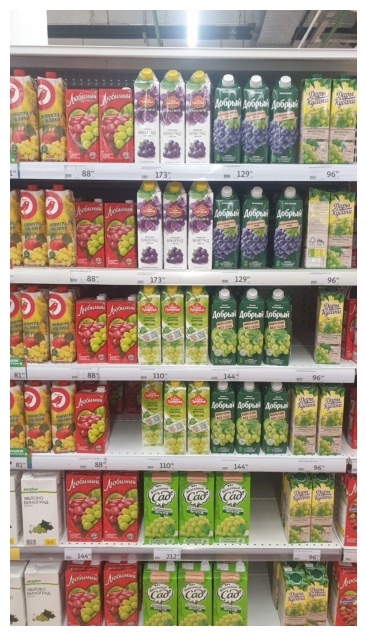

In [3]:
template = cv.imread('train/template_0_1.jpg')
actual = cv.imread('train/train_0.jpg')

actual = actual[:, :, ::-1]
template = template[:, :, ::-1]
plot_img(actual)


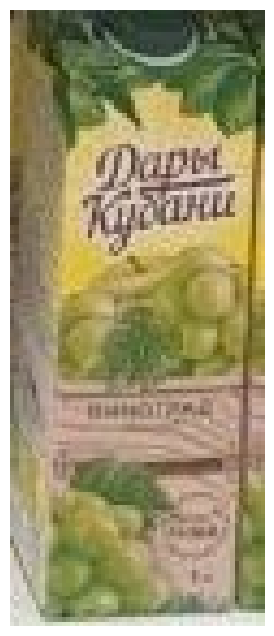

(143, 59, 3)


In [4]:
plot_img(template)
print(template.shape)

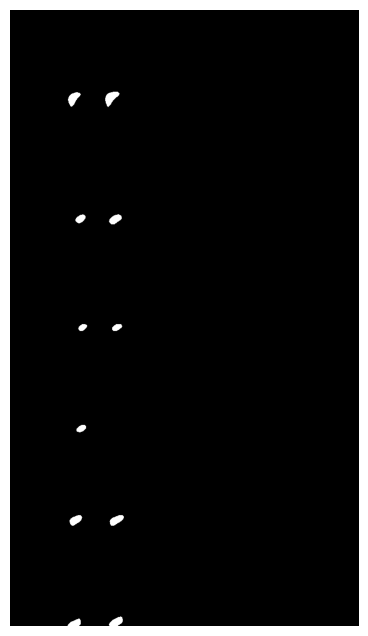

(120, 65, 3)


In [5]:
def predict_coordinates(img, th=0.53): 
    template = cv.imread('train/template_0_0.jpg')
    img = cv.cvtColor(img, cv.COLOR_RGB2LAB)
    template = cv.cvtColor(template, cv.COLOR_RGB2LAB)
    template = template[0:120, 0:65]
    correlation= cv.matchTemplate(img[:, :, 1], template[:, :, 1], method=cv.TM_SQDIFF_NORMED)
    correlation -= correlation.max()
    correlation = np.abs(correlation)
    correlation[correlation < 0.112] = 0
    correlation[correlation != 0] = 1
    return correlation, template.shape
plot_img(predict_coordinates(actual)[0])
print(predict_coordinates(actual)[1])

In [6]:

gray = cv.cvtColor(template, cv.COLOR_RGB2GRAY)

sift = cv.SIFT_create()

kp = sift.detect(gray, None)

img=cv.drawKeypoints(gray, kp, template)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'drawKeypoints'
> Overload resolution failed:
>  - Layout of the output array outImage is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'outImage'


In [8]:
gray_main_img= cv.cvtColor(actual,cv.COLOR_BGR2GRAY)
gray_tamplate = cv.cvtColor(template,cv.COLOR_BGR2GRAY)

# sift = cv.SIFT_create()
# kp = sift.detect(gray,None)
# kp_main_img=cv.drawKeypoints(gray, kp, gray)
# kp_template = cv.drawKeypoints(gray, kp, gray)
# plot_img(i)

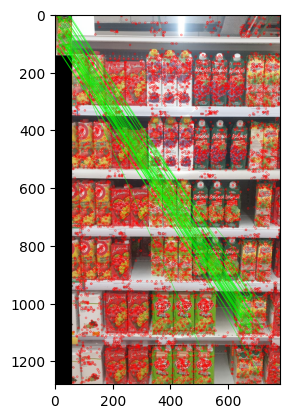

(<matplotlib.image.AxesImage at 0x25733cc7550>, None)

In [9]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = template    # queryImage
img2 = actual# trainImage
 
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# FLANN parameters
FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

In [37]:
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10
def comparing_images(a=5, b=0.1, c=10, d=1.2):
    img1 = cv.cvtColor(template, cv.COLOR_BGR2GRAY)  # queryImage
    img2 = cv.cvtColor(actual, cv.COLOR_BGR2GRAY) # trainImage
    
    orb = cv2.ORB_create()
    #sift = cv2.SIFT_create(15000, a, b, c, d)

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)       ####ключевой метод для нахождения ключевых точек

    import numpy as np
    from sklearn.cluster import MeanShift, estimate_bandwidth

    x = np.array([kp2[0].pt])

    for i in range(len(kp2)):
        x = np.append(x, [kp2[i].pt], axis=0)
    print(x)
    x = x[1:len(x)]

    bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
    ms.fit(x)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print("number of estimated clusters : %d" % n_clusters_)

    s = [None] * n_clusters_
    for i in range(n_clusters_):
        l = ms.labels_
        d, = np.where(l == i)
        print(d.__len__())
        s[i] = list(kp2[xx] for xx in d)

    des2_ = des2

    results = []
    points = []
    for i in range(n_clusters_):
        kp2 = s[i]
        l = ms.labels_
        d, = np.where(l == i)
        des2 = des2_[d, ]
        FLANN_INDEX_LSH = 6
        index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
        # FLANN_INDEX_KDTREE = 1  #for SIFT
        # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)  #for sift
        search_params = dict()

        flann = cv2.FlannBasedMatcher(index_params, search_params)   ###метод для совпадения точек
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        des1 = np.float32(des1)
        des2 = np.float32(des2)
        matches = bf.match(des1,des2)
        #matches = flann.knnMatch(des1, des2, 2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        if len(good) > 3:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)

            if M is None:
                print ("No Homography")
            else:
                matchesMask = mask.ravel().tolist()

                h,w = img1.shape

                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv2.perspectiveTransform(pts,M)
                # points.append(np.int32(dst))
                points.append((dst[0][0][0], dst[0][0][1], np.abs(dst[2][0][0]-dst[0][0][0]), np.abs(dst[2][0][1]-dst[0][0][1])))
                img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

                draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                                singlePointColor=None,
                                matchesMask=matchesMask,  # draw only inliers
                                flags=2)

                img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
                results.append(img3)
                
        else:
            print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
            matchesMask = None
    plt.imshow(results[-1]), plt.show()
    return points

In [34]:
from ipywidgets import IntSlider, FloatSlider, interact

a = IntSlider(min=0, max=100, step=1, value=6)
b = FloatSlider(min=0, max=1, step=0.01, value=0.08) #for sift
c = IntSlider(min=0, max=100, step=1, value=8)
d = FloatSlider(min=0, max=5, step=0.01, value=1.2)

interact(comparing_images, a=a, b=b, c=c, d=d)

interactive(children=(IntSlider(value=6, description='a'), IntSlider(value=4, description='b', max=50), IntSli…

<function __main__.comparing_images(a=5, b=0.1, c=10, d=1.2)>

In [38]:
from ipywidgets import IntSlider, FloatSlider, interact

a = IntSlider(min=0, max=100, step=1, value=6)
b = IntSlider(min =0, max = 50, step = 1, value = 4) #for ORB
c = IntSlider(min=0, max=100, step=1, value=8)
d = FloatSlider(min=0, max=5, step=0.01, value=1.2)

interact(comparing_images, a=a, b=b, c=c, d=d)

interactive(children=(IntSlider(value=6, description='a'), IntSlider(value=4, description='b', max=50), IntSli…

<function __main__.comparing_images(a=5, b=0.1, c=10, d=1.2)>